main
- checkpoint and early stopping (stop when train loss decrease & val loss increase)
- save trained model
- compare model test performance
- check logger system of ignite (+ plot)

models
- resnet
- efficientnet

## colab settings

In [ ]:
import os

prj_name = 'cifar-10'
prj_path = '/content/drive/My Drive/colab/study/image_classification/'\
        + prj_name + '/'
os.chdir(prj_path + 'notebooks/')

## settings

In [ ]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('..')

# main

In [ ]:
from importlib import import_module

import torch
import torch.nn as nn

!pip install pytorch-ignite
from ignite.metrics import Accuracy, Loss

     |████████████████████████████████| 174kB 4.5MB/s 


#### VGG

In [ ]:
# model settings
model_mpath = 'src.models.vgg'
model_name = 'VGG'
model_cfg = {'cfg': [[64], [128], [256, 256], [512, 512], [512, 512]],
        'batch_norm': True}
init_weights = True

# dataset, dataloader settings
batch_size = 2500

# train settings
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam
lr = 0.00003
val_metrics = {'acc': Accuracy(), 'loss': Loss(loss_fn)}
device = 'cuda:0'
max_epochs = 1000

#### InceptionV1

In [ ]:
# model settings
model_mpath = 'src.models.inception_v1'
model_name = 'InceptionV1'
model_cfg = [
        [{1: (0, 64), 3: (96, 128), 5: (16, 32), 'm': 32}, [False, 0, 0], None],
        [{1: (0, 128), 3: (128, 192), 5: (32, 96), 'm': 64}, [True, 3, 2], None],
        [{1: (0, 192), 3: (96, 208), 5: (16, 48), 'm': 64}, [False, 0, 0], None],
        [{1: (0, 160), 3: (112, 224), 5: (24, 64), 'm': 64}, [False, 0, 0], 'aux'],
        [{1: (0, 128), 3: (128, 256), 5: (24, 64), 'm': 64}, [False, 0, 0], None],
        [{1: (0, 112), 3: (144, 288), 5: (32, 64), 'm': 64}, [False, 0, 0], None],
        [{1: (0, 256), 3: (160, 320), 5: (32, 128), 'm': 128}, [True, 2, 2], 'aux'],
        [{1: (0, 256), 3: (160, 320), 5: (32, 128), 'm': 128}, [False, 0, 0], None],
        [{1: (0, 384), 3: (192, 384), 5: (48, 128), 'm': 128}, [False, 0, 0], 'final']
        ]
init_weights = True

# dataset, dataloader settings
batch_size = 2500

# train settings
class loss_cls(nn.Module):
    def __init__(self):
        super(loss_cls, self).__init__()
    def forward(self, inp, tar):
        loss = 0
        loss_fn = nn.CrossEntropyLoss()
        inps = inp.split(10, 1)
        for i, p in enumerate(inps):
            if i < len(inps) - 1:
                loss += 0.3 * loss_fn(p, tar)
            else:
                loss += 1.0 * loss_fn(p, tar)
        return loss
loss_fn = loss_cls()
opt = torch.optim.Adam
lr = 0.00003
val_metrics = {'acc': Accuracy(), 'loss': Loss(loss_fn)}
device = 'cuda:0'
max_epochs = 1000

#### ResNet

In [ ]:
# model settings
model_mpath = 'src.models.resnet'
model_name = 'ResNet'
model_cfg = [
        [(3, 64), (3, 64)],
        [(3, 128), (3, 128)],
        [(3, 256), (3, 256)],
        [(3, 512), (3, 512)]
        ]
init_weights = True

# dataset, dataloader settings
batch_size = 2500

# train settings
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam
lr = 0.00003
val_metrics = {'acc': Accuracy(), 'loss': Loss(loss_fn)}
device = 'cuda:0'
max_epochs = 1000

## load data

In [ ]:
from src.data.make_dataset import Cifar10BatchDataset

dpath = '../data/raw/'

train_folds = []
for i in range(1, 6):
    train_folds.append(torch.load(dpath + 'data_batch_' + str(i) + '.pt'))
test_set = torch.load(dpath + 'test_batch.pt')

In [ ]:
from collections import Counter

for train_fold in train_folds:
    print(sorted(Counter(s['label'] for s in train_fold).items()))
print(sorted(Counter(s['label'] for s in test_set).items()))

[(0, 1005), (1, 974), (2, 1032), (3, 1016), (4, 999), (5, 937), (6, 1030), (7, 1001), (8, 1025), (9, 981)]
[(0, 984), (1, 1007), (2, 1010), (3, 995), (4, 1010), (5, 988), (6, 1008), (7, 1026), (8, 987), (9, 985)]
[(0, 994), (1, 1042), (2, 965), (3, 997), (4, 990), (5, 1029), (6, 978), (7, 1015), (8, 961), (9, 1029)]
[(0, 1003), (1, 963), (2, 1041), (3, 976), (4, 1004), (5, 1021), (6, 1004), (7, 981), (8, 1024), (9, 983)]
[(0, 1014), (1, 1014), (2, 952), (3, 1016), (4, 997), (5, 1025), (6, 980), (7, 977), (8, 1003), (9, 1022)]
[(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


In [ ]:
from torch.utils.data import ConcatDataset, DataLoader

train_set = ConcatDataset([f for j, f in enumerate(train_folds) if j != 4])
val_set = train_folds[4]

train_loader = DataLoader(train_set, batch_size=batch_size,
        shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size,
        shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size,
        shuffle=True, num_workers=2)

del train_folds

## model construction

In [ ]:
model_cls = getattr(
        import_module(model_mpath),
        model_name
        )
model = model_cls(model_cfg, init_weights=init_weights)
for b in model.named_children():
    print(b)
#=============================vgg, inception layers 사이에 relu 꼬박꼬박 껴있는지 확인해라========================

('B_000_000', InV1StartBlock(
  (B_000): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (B_001): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (B_002): ReLU(inplace=True)
  (B_003): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (B_004): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (B_005): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (B_006): ReLU(inplace=True)
  (B_007): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (B_008): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (B_009): ReLU(inplace=True)
  (B_010): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
))
('B_001_000', InV1InceptBlock(
  (B_001_000): InV1InConvBlock(
    (B_000): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (B_001): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [ ]:
#============================ResNet=============================================
class RNConvBlock(nn.Module):
    """
    cfg = [(ksize1, n_otpch1), (ksize2, n_otpch2), (ksize3, n_otpch3)]
    """
    def __init__(self, n_inpch, cfg):
        super(RNConvBlock, self).__init__()
        self.blocks = []
        self.make_net(n_inpch, cfg)

    def forward(self, x):
        for b in self.blocks:
            x = b(x)
        return x

    def make_net(self, n_inpch, cfg):
        for i, (ksize, n_otpch) in enumerate(cfg):
            self.blocks.append(nn.Conv2d(n_inpch, n_otpch,
                    kernel_size=ksize, padding=(ksize // 2)))
            self.blocks.append(nn.BatchNorm2d(n_otpch))
            if i < len(cfg) - 1:
                self.blocks.append(nn.ReLU(True))
            n_inpch = n_otpch
        for i, b in enumerate(self.blocks):
            self.add_module('B_' + str(i).zfill(3), b)

class RNResBlock(nn.Module):
    """
    cfg = [(ksize1, n_otpch1), (ksize2, n_otpch2), (ksize3, n_otpch3)]
    """
    def __init__(self, n_inpch, cfg):
        super(RNResBlock, self).__init__()
        self.blocks = [[]]
        self.make_net(n_inpch, cfg)

    def forward(self, x):
        x = self.blocks[0][0](x) + self.blocks[0][1](x)
        x = self.blocks[1](x)
        return x

    def make_net(self, n_inpch, cfg):
        self.blocks[0].append(nn.Identity())
        self.blocks[0].append(RNConvBlock(n_inpch, cfg))
        self.blocks.append(nn.ReLU(True))
        for i, b in enumerate(self.blocks[0], 1):
            self.add_module('B_000_' + str(i).zfill(3), b)
        self.add_module('B_001', self.blocks[1])
            
class RNClfBlock(nn.Module):
    def __init__(self, n_inpch, n_otp):
        super(RNClfBlock, self).__init__()
        self.blocks = []
        self.make_net(n_inpch, n_otp)

    def forward(self, x):
        for b in self.blocks:
            x = b(x)
        return x

    def make_net(self, n_inpch, n_otp):
        self.blocks.append(nn.AdaptiveAvgPool2d((1, 1)))
        self.blocks.append(nn.Flatten())
        self.blocks.append(nn.Linear(n_inpch, n_otp))
        for i, b in enumerate(self.blocks):
            self.add_module('B_' + str(i).zfill(3), b)

class ResNet(nn.Module): #=========================시작부분 만들어라=======================
    def __init__(self, cfg, n_otp=10, init_weights=False):
        super(ResNet, self).__init__()
        self.blocks = []
        self.make_net(cfg, n_otp)
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        for b in self.blocks:
            x = b(x)
        return  x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                        nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def make_net(self, cfg, n_otp):
        n_inpch = 3
        for c in cfg:
            self.blocks.append(RNResBlock(n_inpch, c))
            n_inpch = c[- 1][1]
        self.blocks.append(RNClfBlock(n_inpch, n_otp))
        for i, b in enumerate(self.blocks):
            self.add_module('B_' + str(i).zfill(3), b)
        

In [ ]:
model = ResNet(model_cfg)
for b in model.named_children():
    print(b)

('B_000', RNResBlock(
  (B_000_001): Identity()
  (B_000_002): RNConvBlock(
    (B_000): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (B_001): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (B_002): ReLU(inplace=True)
    (B_003): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (B_004): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (B_001): ReLU(inplace=True)
))
('B_001', RNResBlock(
  (B_000_001): Identity()
  (B_000_002): RNConvBlock(
    (B_000): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (B_001): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (B_002): ReLU(inplace=True)
    (B_003): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (B_004): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (B_001): ReLU(inplace=True)
))
('B_002', RNResBlo

## train

In [ ]:
import torchvision # 이따 집에서 test해보자 얘도 60% 언저리에서 끝나는지
model = torchvision.models.vgg11(pretrained=False, progress=True)

In [ ]:
from src.models.train_model import train_net

opt = opt(model.parameters(), lr)

trainer = train_net(model, opt, loss_fn, val_metrics,
        train_loader, val_loader, device)
trainer.run(train_loader, max_epochs=max_epochs)

Epoch 1
Train - acc: 0.10 loss: 2.46 
Val   - acc: 0.10 loss: 2.47 
Epoch 2
Train - acc: 0.10 loss: 2.49 
Val   - acc: 0.10 loss: 2.49 
Epoch 3
Train - acc: 0.12 loss: 2.32 
Val   - acc: 0.12 loss: 2.32 
Epoch 4
Train - acc: 0.16 loss: 2.34 
Val   - acc: 0.15 loss: 2.35 
Epoch 5
Train - acc: 0.14 loss: 2.31 
Val   - acc: 0.14 loss: 2.31 
Epoch 6
Train - acc: 0.16 loss: 2.26 
Val   - acc: 0.16 loss: 2.26 
Epoch 7
Train - acc: 0.20 loss: 2.09 
Val   - acc: 0.20 loss: 2.09 
Epoch 8
Train - acc: 0.22 loss: 2.03 
Val   - acc: 0.22 loss: 2.03 
Epoch 9
Train - acc: 0.26 loss: 1.94 
Val   - acc: 0.26 loss: 1.95 
Epoch 10
Train - acc: 0.29 loss: 1.85 
Val   - acc: 0.29 loss: 1.86 
Epoch 11
Train - acc: 0.32 loss: 1.78 
Val   - acc: 0.32 loss: 1.78 
Epoch 12
Train - acc: 0.34 loss: 1.72 
Val   - acc: 0.34 loss: 1.73 
Epoch 13
Train - acc: 0.37 loss: 1.66 
Val   - acc: 0.37 loss: 1.67 
Epoch 14
Train - acc: 0.39 loss: 1.60 
Val   - acc: 0.39 loss: 1.62 
Epoch 15
Train - acc: 0.41 loss: 1.57 
Val 

## Test

'asd12'

In [ ]:
from src.models.vgg import VGG

vgg11_cfg = [[64], [128], [256, 256], [512, 512], [512, 512]]
vgg11 = VGG(vgg11_cfg)
for b in vgg11.named_children():
    print(b)

1:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.10, v: 0.10


2:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.10, v: 0.10


3:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.10, v: 0.10


4:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.12, v: 0.15


5:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.11, v: 0.12


6:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.13, v: 0.14


7:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.14, v: 0.15


8:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.15, v: 0.15


9:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.16, v: 0.18


10:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.17, v: 0.19


11:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.18, v: 0.19


12:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.19, v: 0.21


13:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.17, v: 0.18


14:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.18, v: 0.19


15:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.16, v: 0.19


16:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.19, v: 0.20


17:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.20, v: 0.21


18:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.21, v: 0.22


19:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.21, v: 0.22


20:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.21, v: 0.20


21:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.20, v: 0.21


22:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.20, v: 0.20


23:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.21, v: 0.22


24:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.22, v: 0.22


25:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.22, v: 0.24


26:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.23, v: 0.24


27:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.24, v: 0.24


28:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.25, v: 0.25


29:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.26, v: 0.26


30:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.26, v: 0.27


31:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.27, v: 0.27


32:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.26, v: 0.26


33:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.26, v: 0.26


34:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.26, v: 0.28


35:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.28, v: 0.30


36:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.29, v: 0.30


37:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.30, v: 0.29


38:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.29, v: 0.27


39:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.29, v: 0.31


40:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.30, v: 0.31


41:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.31, v: 0.31


42:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.31, v: 0.31


43:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.32, v: 0.33


44:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.33, v: 0.34


45:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.34, v: 0.35


46:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.34, v: 0.35


47:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.34, v: 0.35


48:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.34, v: 0.35


49:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.35, v: 0.37


49: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


t: 0.35, v: 0.37


ValueError: ignored

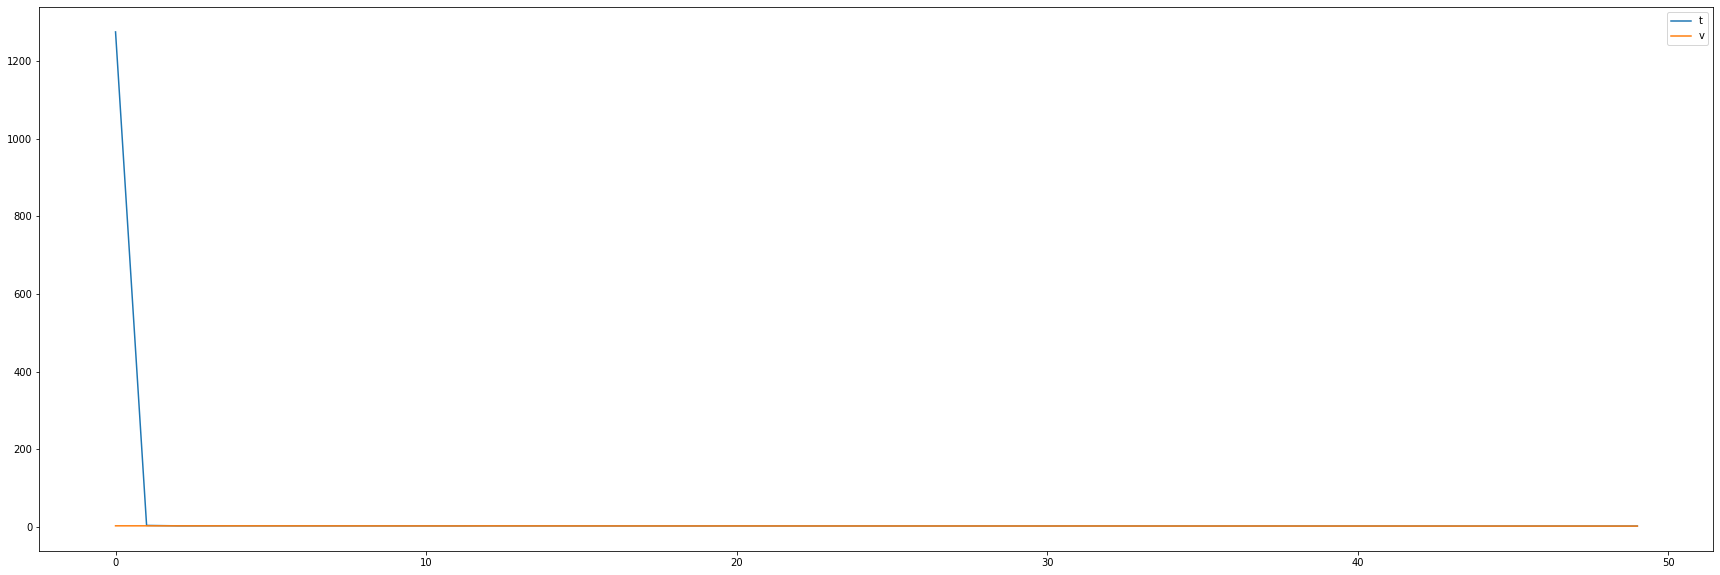

In [ ]:
# 수동으로 다 짜는 뻘짓이였다.

from src.models.train_model import train_net

from torch.utils.data import ConcatDataset, DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt

loss_fn = nn.CrossEntropyLoss()
device = 'cuda:0'

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(30, 10))
test_loader = DataLoader(test_set, batch_size=64,
        shuffle=True, num_workers=2)
fold_models = []
for i in range(5):
    # ====================random state, vgg11 copy for each fold
    train_set = ConcatDataset([f for j, f in enumerate(train_folds) if j != i])
    val_set = train_folds[i]
    train_loader = DataLoader(train_set, batch_size=5000,
            shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=5000,
            shuffle=True, num_workers=2)

    opt = Adam(vgg11.parameters(), lr=0.03)
    tl, ta, vl, va = train_net(vgg11, opt, loss_fn, 50,
            train_loader, val_loader, device, ax)

    break

In [ ]:
import torch
import torch.nn.functional as F
input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(5, (3,), dtype=torch.int64)
loss = F.cross_entropy(input, target)
loss.backward()

In [ ]:
input

tensor([[ 1.3824, -0.9514, -0.5539, -1.1105, -0.6623],
        [ 0.4279,  0.1307,  2.1382,  1.0987, -0.8870],
        [ 2.0576, -1.8201, -1.3227,  0.3146, -0.8222]], requires_grad=True)

In [ ]:
target

tensor([2, 0, 1])

In [ ]:
loss

tensor(2.8968, grad_fn=<NllLossBackward>)

In [ ]:
from itertools import repeat

class Sampyo(nn.Module):
    def __init__(self):
        super(Sampyo, self).__init__()
        self.layers = [nn.Linear(2, 2), nn.Linear(2, 2), nn.Linear(2, 2)]
        for i, m in enumerate(self.layers):
            self.add_module(m.__class__.__name__ + str(i), m)
        self.layman = nn.Linear(2, 2)



In [ ]:
sampyo = Sampyo()
for i, m in enumerate(sampyo.named_modules()):
    print(i, m)
print('==========================================')
for i, m in enumerate(sampyo.named_children()):
    print(i, m)
print('==========================================')
for i, m in enumerate(
            sampyo._named_members((lambda m: zip(repeat(''), m.layers)),
                    recurse=False)):
    print(i, m)

0 ('', Sampyo(
  (layman): Linear(in_features=2, out_features=2, bias=True)
))
1 ('layman', Linear(in_features=2, out_features=2, bias=True))
0 ('layman', Linear(in_features=2, out_features=2, bias=True))
0 ('', Linear(in_features=2, out_features=2, bias=True))
1 ('', Linear(in_features=2, out_features=2, bias=True))
2 ('', Linear(in_features=2, out_features=2, bias=True))


In [ ]:
sampyo = Sampyo()
for i, m in enumerate(sampyo.named_modules()):
    print(i, m)
print('==========================================')
for i, m in enumerate(sampyo.named_children()):
    print(i, m)
print('==========================================')
for i, m in enumerate(
            sampyo._named_members((lambda m: zip(repeat(''), m.layers)),
                    recurse=False)):
    print(i, m)

0 ('', Sampyo(
  (Linear0): Linear(in_features=2, out_features=2, bias=True)
  (Linear1): Linear(in_features=2, out_features=2, bias=True)
  (Linear2): Linear(in_features=2, out_features=2, bias=True)
  (layman): Linear(in_features=2, out_features=2, bias=True)
))
1 ('Linear0', Linear(in_features=2, out_features=2, bias=True))
2 ('Linear1', Linear(in_features=2, out_features=2, bias=True))
3 ('Linear2', Linear(in_features=2, out_features=2, bias=True))
4 ('layman', Linear(in_features=2, out_features=2, bias=True))
0 ('Linear0', Linear(in_features=2, out_features=2, bias=True))
1 ('Linear1', Linear(in_features=2, out_features=2, bias=True))
2 ('Linear2', Linear(in_features=2, out_features=2, bias=True))
3 ('layman', Linear(in_features=2, out_features=2, bias=True))
0 ('', Linear(in_features=2, out_features=2, bias=True))
1 ('', Linear(in_features=2, out_features=2, bias=True))
2 ('', Linear(in_features=2, out_features=2, bias=True))
